In [1]:
import numpy as np
import pandas as pd  
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import power_transform

from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# from sklearn.datasets import load_boston
# boston_dataset = load_boston()
# boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
# boston.head()

In [3]:
data = sm.datasets.engel.load_pandas().data
data.head(10)

income     foodexp
0   420.157651  255.839425
1   541.411707  310.958667
2   901.157457  485.680014
3   639.080229  402.997356
4   750.875606  495.560775
5   945.798931  633.797815
6   829.397887  630.756568
7   979.164836  700.440904
8  1309.878940  830.958622
9  1492.398744  815.360217

In [4]:
data.describe()

income      foodexp
count   235.000000   235.000000
mean    982.473044   624.150111
std     519.230879   276.456997
min     377.058369   242.320202
25%     638.875788   429.688763
50%     883.984917   582.541251
75%    1163.986672   743.881432
max    4957.813024  2032.679190

In [5]:
data.shape

(235, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   income   235 non-null    float64
 1   foodexp  235 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB


In [7]:
data.isna().mean()

income     0.0
foodexp    0.0
dtype: float64

In [8]:
# plt.hist(data.income, bins = 10)
sns.distplot(data.income)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [9]:
# y_box_cox = power_transform(np.expand_dims(data.income, axis=1), method='box-cox').flatten()
# sns.distplot(a=y_box_cox, kde=True)

In [10]:
data.income.skew()

2.7986231725285586

In [11]:
data.foodexp.skew()

1.7223553604955857

In [12]:
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(data['income'], data['foodexp'])
print('Pearsons correlation: %.3f' % corr)

from scipy.stats import spearmanr
# calculate spearman's correlation
corr, _ = spearmanr(data['income'], data['foodexp'])
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.911
Spearmans correlation: 0.938


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='foodexp', ylabel='Density'>

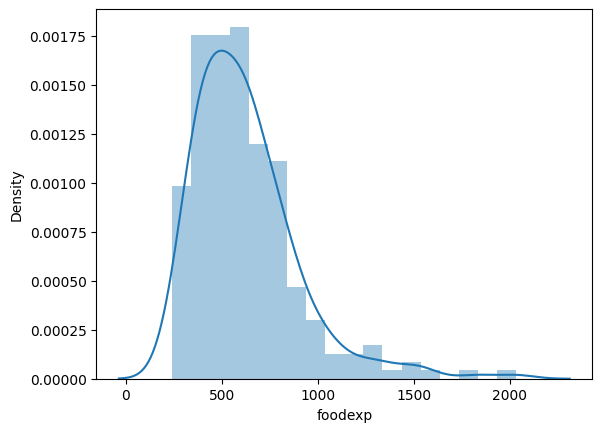

In [13]:
sns.distplot(data.foodexp)

In [14]:
# y_box_cox = power_transform(np.expand_dims(data.foodexp, axis=1), method='box-cox').flatten()
# sns.distplot(a=y_box_cox, kde=True)

/usr/local/lib/python3.10/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income'>

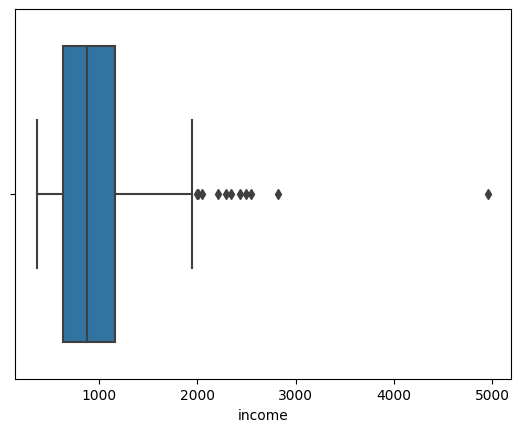

In [15]:
sns.boxplot(data.income)

In [16]:
sns.boxplot(data.foodexp)

/usr/local/lib/python3.10/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='foodexp'>

 ## Least Absolute Deviation
## The LAD model is a special case of quantile regression where q=0.5

In [17]:
mod = smf.quantreg('foodexp ~ income', data)
# mod
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Mon, 14 Nov 2022   No. Observations:                  235
Time:                        12:24:24   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


## Visualizing the results
We estimate the quantile regression model for many quantiles between .025 and .98, and compare best fit line from each of these models to Ordinary Least Squares results.

In [18]:
quantiles = np.arange(0.025, 0.975, 0.1)

def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + res.conf_int().loc['income'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns = ['q', 'Intercept', 'income', 'LB', 'UB'])

ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist() # "ols.conf_int" will give the lower and upper bounds
ols = dict(a = ols.params['Intercept'], 
          b = ols.params['income'],
          lb = ols_ci[0], 
          ub = ols_ci[1])

print(models)
print("\n")
print(ols)

       q   Intercept    income        LB        UB
0  0.025  109.461087  0.346471  0.257959  0.434983
1  0.125  110.303431  0.409106  0.363667  0.454544
2  0.225  100.750012  0.458456  0.422233  0.494680
3  0.325  106.080084  0.479873  0.447725  0.512022
4  0.425   98.547120  0.518995  0.489226  0.548764
5  0.525   91.537392  0.555628  0.530086  0.581170
6  0.625   84.067242  0.585532  0.562750  0.608313
7  0.725   61.687333  0.640250  0.618198  0.662302
8  0.825   59.885090  0.660106  0.640634  0.679578
9  0.925   64.851155  0.697185  0.669069  0.725301


{'a': 147.47538852370573, 'b': 0.48517842367692354, 'lb': 0.4568738130184233, 'ub': 0.5134830343354237}


## First plot
This plot compares best fit lines for 10 quantile regression models to the least squares fit. As Koenker and Hallock (2001) point out, we see that:

1). Food expenditure increases with income.

2). The dispersion of food expenditure increases with income.

3). The least squares estimates fit low income observations quite poorly (i.e. the OLS line passes over most low income households).

In [19]:
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8,6))

for i in range(models.shape[0]):
    y = get_y(models.Intercept[i], models.income[i])
    ax.plot(x, y, linestyle = 'dotted', color = 'grey')
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Income', fontsize = 16)
ax.set_ylabel('Food Expenditure', fontsize = 16);

## Second plot
The dotted black lines form 95% point-wise confidence band around 10 quantile regression estimates (solid black line). The red lines represent OLS regression results along with their 95% confindence interval.

In most cases, the quantile regression point estimates lie outside the OLS confidence interval, which suggests that the effect of income on food expenditure may not be constant across the distribution.

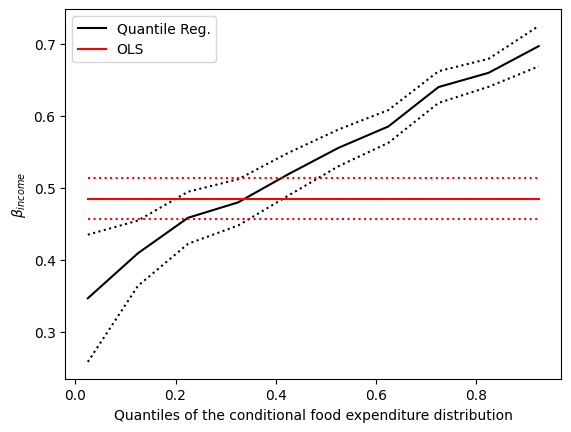

In [20]:
n = models.shape[0]

p1 = plt.plot(models.q, models.income, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.UB, color='black', linestyle='dotted')
p3 = plt.plot(models.q, models.LB, color='black', linestyle='dotted')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
P5 = plt.plot(models.q, [ols['lb']] * n, color='red', linestyle='dotted')
p6 = plt.plot(models.q, [ols['ub']] * n, color='red', linestyle='dotted')

plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show();

In [21]:
X = data.income
y = data.foodexp

## Logrithm Transformation
y= a+ b* log(x)

In [22]:
# # Input dataset
# X_log = np.log(data['income'].values.reshape(-1,1))

# # Output or Predicted Value of data
# y_log = data['foodexp'].values.reshape(-1,1)

In [23]:
 from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state= 2529)
X_train.shape

(157,)

In [25]:
X_train = X_train.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
X_train.shape

(157, 1)

In [26]:
import lightgbm as lgb

In [27]:
def lgb_model(q):
    model = lgb.LGBMRegressor(
        objective = 'quantile',
        alpha = q,
        learning_rate = 0.05,
        n_estimators = 1000,
        min_data_in_leaf=5,
        num_leaves = 100000,
        bagging_fraction=0.95,
        feature_fraction = 0.95,
        max_depth = 10,
        random_state = 12,
        num_threads = -1
    )
    model.fit(X_train,y_train)
    score = model.score(X_train,y_train)
    print(f'quantile {q} score: {round(score,3)}')
    y_pred = model.predict(X_test)
    return y_pred

In [28]:
sub = pd.DataFrame()
# sub['Income']  = data.income[0:78]
sub['q0.05'] = lgb_model(0.05)
sub['q0.5'] = lgb_model(0.5)
sub['q0.95'] = lgb_model(0.95)

/home/rahul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
quantile 0.05 score: 0.697
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/home/rahul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


quantile 0.5 score: 0.867
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/home/rahul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


quantile 0.95 score: 0.507


In [29]:
OLS = LinearRegression()
OLS.fit(X_train, y_train)

LinearRegression()

In [30]:
# model evaluation for testing set
y_test_predict = OLS.predict(X_test)
r2 = metrics.r2_score(y_test, y_test_predict).round(2)
print('R2 score is {}'.format(r2) )

R2 score is 0.62


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

In [32]:
# clf = GradientBoostingRegressor(loss='quantile', alpha = 0.5)

In [33]:
# clf.fit(X_train,y_train)

# score = clf.score(X_train,y_train)

# y_pred1 = clf.predict(X_test)

# r2 = metrics.r2_score(y_test, y_pred1).round(2)
# print('R2 score is {}'.format(r2) )

## GradientBoostingRegressor

In [34]:
alpha = 0.5
clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(X_train,y_train)
# Make the prediction on the meshed x-axis
y_pred = clf.predict(X_test)

y_lower = GradientBoostingRegressor(loss='quantile', alpha = 1.0-0.95)

# clf.set_params(alpha=1.0 - 0.95)
y_lower.fit(X_train,y_train)
# Make the prediction on the meshed x-axis
y_lower1 = y_lower.predict(X_test)

y_upper = GradientBoostingRegressor(loss='quantile', alpha = 0.95)
y_upper.fit(X_train,y_train)
# Make the prediction on the meshed x-axis
y_upper1 = y_upper.predict(X_test)

# y_upper ,y_lower1 ,y_pred1

/home/rahul/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rahul/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rahul/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
sc = r2_score(y_test, y_pred)
print(sc)

0.7673704471039986


## LGBMRegressor

In [36]:
from lightgbm import LGBMRegressor

In [37]:
lgb = LGBMRegressor(
        objective = 'quantile',
        alpha = 0.5,
        learning_rate = 0.04,
        n_estimators = 1000,
        min_data_in_leaf=5,
        num_leaves = 100000,
        bagging_fraction=0.95,
        feature_fraction = 0.95,
        max_depth = 10,
        random_state = 12,
        num_threads = -1
    )

In [38]:
lgb.fit(X_train,y_train)
score1 = lgb.score(X_train,y_train)
y_pred3 = lgb.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred3).round(2)
print('R2 score is {}'.format(r2)) 

/home/rahul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
R2 score is 0.78


In [39]:
lower = LGBMRegressor(objective = 'quantile', alpha = 1 - 0.95)
lower.fit(X_train, y_train)
lower_pred = lower.predict(X_test)
# lower_pred

/home/rahul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
upper = LGBMRegressor(objective = 'quantile', alpha = 0.95)
upper.fit(X_train, y_train)
upper_pred = upper.predict(X_test)
# upper_pred

/home/rahul/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
score = r2_score(y_test, y_pred3)
print(score)

0.7786789750997423


In [42]:
# def gbr_model(q):
#     model1 = GradientBoostingRegressor(
#         loss = 'quantile',
#         alpha = q,
#         learning_rate = 0.05,
#         n_estimators = 1000,
#         random_state = 12,
#     )
#     model1.fit(X_train,y_train)
#     score = model1.score(X_train,y_train)
#     print(f'quantile {q} score: {round(score,3)}')
#     y_pred = model1.predict(X_test)
#     return y_pred

In [43]:
# sub1 = pd.DataFrame()
# sub['Income']  = data.income[0:78]
# sub['q0.05'] = gbr_model(0.05)
# sub['q0.5'] = gbr_model(0.5)
# sub['q0.95'] = gbr_model(0.95)

In [44]:
import pickle

In [45]:
# pickle.dump(ols, open('quareg.pkl', 'wb'))

In [46]:
# pickle.dump(models, open('quareg.pkl', 'wb'))

In [47]:
# pickle.dump(OLS, open('quareg.pkl', 'wb'))

In [48]:
# pickle.dump(lgb, open('quareg.pkl', 'wb')) # lightgbm

In [49]:
# pickle.dump(clf, open('quareg.pkl', 'wb')) # gradientboostregressor

In [50]:
# pickle.dump(y_upper, open('quareglower.pkl', 'wb')) # gradientboostregressor

In [51]:
# pickle.dump(y_lower, open('quaregupper.pkl', 'wb')) # gradientboostregressor

In [52]:
# mp = pickle.load(open('quareg.pkl','rb'))

In [53]:
# mpl = pickle.load(open('quareglower.pkl','rb'))

In [54]:
# mpu = pickle.load(open('quaregupper.pkl','rb'))

In [55]:
# mp.predict([[76655464.75]])

In [56]:
# mpu.predict([[76655464.75]])

In [57]:
# mpl.predict([[76655464.75]])

In [58]:
# joblib
import joblib

In [59]:
joblib.dump(clf , 'clf_joblib')

['clf_joblib']

In [60]:
joblib.dump(y_upper , 'clf_joblibub')

['clf_joblibub']

In [61]:
joblib.dump(y_lower , 'clf_jobliblb')

['clf_jobliblb']

In [62]:
# clf.fit(X_train)
# y_pred = clf.predict(X_test)

In [63]:
cup = joblib.load('clf_joblibub')

In [64]:
# clb = joblib.load('clf_jobliblb')

In [65]:
ccc = joblib.load('clf_joblib')

In [76]:
#var = (7655.7658,8)
ccc.predict([[7655.7658]])

array([1263.75738795])

In [ ]:
ccc.predict([[7655.7658]])

In [ ]:
cup.predict([[7655.7658]])

In [ ]:
clb.predict([[7655.7658]])

In [ ]:
# import statsmodels.regression.quantile_regression as Q_reg

In [ ]:
# quantiles = [0.01, 0.05, 0.50, 0.95 , 0.99]

# # Get the model, and the cofficients in (a) - (b)

# def Qreg(q):
    
#    # (a) Modeling 
#    mod = Q_reg.QuantReg(y_train, X_train).fit(q=q)
    
#    # (b) Get the coefficients and the lower and upper bounds
#    coefs = pd.DataFrame()
#    coefs['param'] = mod.params
#    coefs = pd.concat([coefs,mod.conf_int()],axis=1) # "mod.conf_int" will give the lower and upper bounds
#    coefs['q'] = q
#    coefs.columns = ['beta','beta_lower','beta_upper','quantile']
    
#    return coefs

# Qreg_coefs = pd.DataFrame()
# coefs = pd.Series()
# for q in quantiles:
#     coefs = Qreg(q)
#     Qreg_coefs = pd.concat([Qreg_coefs,coefs])
#     print(coefs)

# Qreg(0.25)


# # Get the R-squared for Q=0.5
# q = 0.5
# y_test_pred = Q_reg.QuantReg(y_train, X_train).fit(q=q).predict(X_test)
# r2 = metrics.r2_score(y_test,y_test_pred)
# print('R2 score is {}'.format(r2) ) # 0.75